<a href="https://colab.research.google.com/github/valtanenamanda/Adaml/blob/main/adaml_workshop_4_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADAML Workshop 4: Transformer and Transfer Learning

## 0. Study how the Transformer works
Go through this website and study the inner workings of the transformer model

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch?dc_referrer=https%3A%2F%2Fwww.google.com%2F

## 1. Test the model performance with the test set (2p)

## 2. Experiment with adding and training layers (3p)
Try to get better accuracy than with just the trained classification head.

## 3. Experiment with different pre-trained models (2p)

## 4. Comment the notebook clearly and report what architecture you used for the best results (1p)


In [1]:
!pip install evaluate
from datasets import load_dataset
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import numpy as np
import torch.nn as nn
import evaluate

import wandb
wandb.init(mode="disabled")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [2]:
dataset = load_dataset("emotion")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [87]:
pretrained_model_name = "distilbert-base-uncased"
#pretrained_model_name = "bert-base-uncased"
#pretrained_model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

def tokenize_function(row):
    return tokenizer(row["text"], truncation=True)

token_data = dataset.map(tokenize_function, batched=True)
token_data = token_data.remove_columns(["text"])
token_data = token_data.rename_column("label", "labels")
token_data.set_format("torch")

small_train = token_data["train"].shuffle(seed=42).select(range(1000))
small_test = token_data["test"].shuffle(seed=42).select(range(1000))
batch_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [88]:
labels = dataset["train"].features["label"].num_classes
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=labels)

hidden = model.pre_classifier.out_features
print(hidden)

model.classifier = nn.Sequential(
    nn.Linear(hidden, 1000),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(1000, labels)
)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head parameters
for name, param in model.named_parameters():
    if "classifier" in name or "pre_classifier" in name or "distilbert.transformer.layer.5" in name:
        param.requires_grad = True

# Verify which parameters are trainable
print("Trainable parameters after freezing:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768
Trainable parameters after freezing:
distilbert.transformer.layer.5.attention.q_lin.weight
distilbert.transformer.layer.5.attention.q_lin.bias
distilbert.transformer.layer.5.attention.k_lin.weight
distilbert.transformer.layer.5.attention.k_lin.bias
distilbert.transformer.layer.5.attention.v_lin.weight
distilbert.transformer.layer.5.attention.v_lin.bias
distilbert.transformer.layer.5.attention.out_lin.weight
distilbert.transformer.layer.5.attention.out_lin.bias
distilbert.transformer.layer.5.sa_layer_norm.weight
distilbert.transformer.layer.5.sa_layer_norm.bias
distilbert.transformer.layer.5.ffn.lin1.weight
distilbert.transformer.layer.5.ffn.lin1.bias
distilbert.transformer.layer.5.ffn.lin2.weight
distilbert.transformer.layer.5.ffn.lin2.bias
distilbert.transformer.layer.5.output_layer_norm.weight
distilbert.transformer.layer.5.output_layer_norm.bias
pre_classifier.weight
pre_classifier.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [89]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [90]:
model_name = "distilbert-base-finetuned"
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)

In [91]:
model_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    data_collator=batch_collator,
    compute_metrics=compute_metrics,
)
model_trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.600100,1.264012,0.584000
2,1.216600,1.111267,0.653000
3,1.022500,0.867089,0.720000
4,0.889500,0.919284,0.722000
5,0.758200,0.940929,0.707000
6,0.628000,0.987552,0.692000
7,0.595600,0.844502,0.734000
8,0.382000,0.966007,0.741000
9,0.331000,1.025122,0.748000
10,0.200500,0.978047,0.764000


TrainOutput(global_step=630, training_loss=0.7624141920180548, metrics={'train_runtime': 144.7308, 'train_samples_per_second': 69.094, 'train_steps_per_second': 4.353, 'total_flos': 126826625345760.0, 'train_loss': 0.7624141920180548, 'epoch': 10.0})

In [92]:
text = ("I really enjoy using pretrained neural networks, since it allows training large networks faster.")
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

prediction = classifier(text)
print(prediction)
print(dataset["train"].features["label"].names)

Device set to use cuda:0


[{'label': 'LABEL_4', 'score': 0.758888840675354}]
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [93]:
model_trainer.evaluate()

{'eval_loss': 0.9780471324920654,
 'eval_accuracy': 0.764,
 'eval_runtime': 0.902,
 'eval_samples_per_second': 1108.637,
 'eval_steps_per_second': 69.844,
 'epoch': 10.0}

In [94]:
pred_output = model_trainer.predict(small_test)

In [95]:
preds = np.argmax(pred_output.predictions, axis=1)
labels = pred_output.label_ids

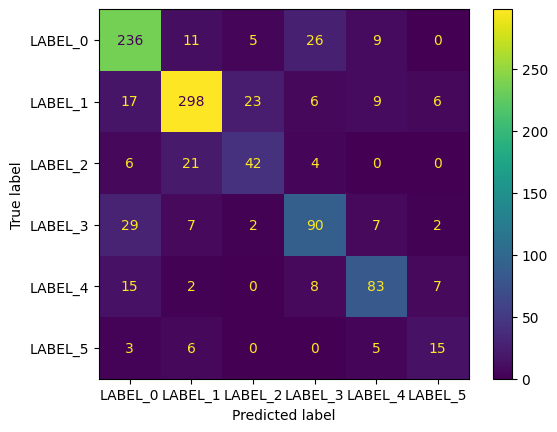

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.config.id2label.values()
)

disp.plot()
plt.show()

The goal of this work was to classify sentences into emotional categories using a transformer-based model. With the original pre-trained model, the evaluation accuracy reached 53%, and especially classes 2–5 were frequently misclassified as classes 1 or 2. I then extended the classification head by adding a lightweight layer structure (linear–tanh–dropout–linear), which increased the test accuracy to 54.6%. Based on the confusion matrix, the classification of class 3 improved compared to the original model, although adding more layers did not clearly improve the results further within 10 training epochs.



I also tested other pre-trained models combined with my custom classification layers, but most of them did not show meaningful improvement. The only significant gain came from using a model that had already been trained specifically for emotion recognition, with which I achieved an accuracy of 92.6%. Furthermore, by lowering the learning rate in the original model with added layers, I reached an accuracy of 55.2%, while changing the batch size did not lead to major improvements. Unfreezing the fifth transformer layer increased the accuracy to 76.4%.

The confusion matrix indicated that the most common misclassifications occurred between the classes “sadness” and “anger”, and between “joy” and “love”, which is reasonable considering the similarity of these emotions. I also noticed that the dataset was imbalanced, which should have been addressed in the experiments. Increasing the number of training epochs would likely have improved the results further.

I had no prior experience in extending transformer models with extra layers. I learned that pre-trained models can be modified in this way to better fit for a more specific task.